# 1)- Introduction

- The momentum trading strategy consists of creating buying/selling signals based on various time framed moving averages of an asset's price action or volume (2-days MA, 3-weeks MA, etc..). In general, we follow the momentum of the price action by buying low and selling high.

- Just like the ARIMA notebook, we are going to conduct our data analytics using AAPL stock over the last 200 days. The financial data is from YahooFinance package.


In [2]:
!pip install yfinance

     |████████████████████████████████| 6.4 MB 27.2 MB/s 
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [10]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np

# 2)- How choose the MA time frame?

- A critical component of a momentum trading strategy is the choice of the right time frame over which we compute our moving averages. This time frame can determine how successful our strategy will be. In my case, I decided to choose a medium sized time frame of 25 days, and then compute the 25-d MA price action and volume.
- First, let's load our AAPL stock data for the last 200 days from YahooFinance:

In [24]:
aapl = yf.Ticker("AAPL")
df_apple = aapl.history(start="2021-6-1", end="2021-12-18", interval="1d")
df_apple.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2021-06-01,124.710873,124.980073,123.574238,123.913231,67637100,0.0,0
2021-06-02,123.913229,124.870395,123.683912,124.690926,59278900,0.0,0
2021-06-03,124.312050,124.481547,122.766621,123.175415,76229200,0.0,0
2021-06-04,123.703850,125.787686,123.484498,125.518478,75169300,0.0,0
2021-06-07,125.797650,125.947209,124.461608,125.528450,71057600,0.0,0


In [25]:
# Dataset shape
df_apple.shape

(141, 7)

- We can see that the dataset contains only 141 samples, instead of 200. This is because weekends and holidays are not accounted for as trading days. Now that we got the data, let's compute the 25-d MA over close prices and volumes.
- We will also have empty values in the first 24 days of the computed moving averages, since there are not enough data to compute over.

In [26]:
# Let's compute the 5-d, 15-d and 25-d MA for visualization
df_apple["5d_ma_price"] = df_apple['Close'].rolling(5).mean()
df_apple["15d_ma_price"] = df_apple['Close'].rolling(15).mean()
df_apple["25d_ma_price"] = df_apple['Close'].rolling(25).mean()

# The 25-d MA for trading volume
df_apple["25d_ma_volume"] = df_apple['Volume'].rolling(25).mean()
df_apple = df_apple[df_apple["25d_ma_price"].notna()]
df_apple.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,5d_ma_price,15d_ma_price,25d_ma_price,25d_ma_volume
Date,,,,,,,,,,,
2021-07-06,139.656634,142.727531,139.656634,141.600876,108181800,0.0,0,138.099243,133.994057,130.746602,73844408.0
2021-07-07,143.116382,144.462404,142.238989,144.143356,104911600,0.0,0,139.742383,134.986454,131.555807,75335388.0
2021-07-08,141.162171,143.634848,140.254853,142.817276,105575500,0.0,0,140.994675,135.856546,132.280862,77187252.0
2021-07-09,142.328727,145.220162,142.229016,144.681763,99890800,0.0,0,142.558047,136.741926,133.141115,78133716.0
2021-07-12,145.778507,145.888183,143.575023,144.073547,76299700,0.0,0,143.463364,137.675163,133.883318,78178932.0


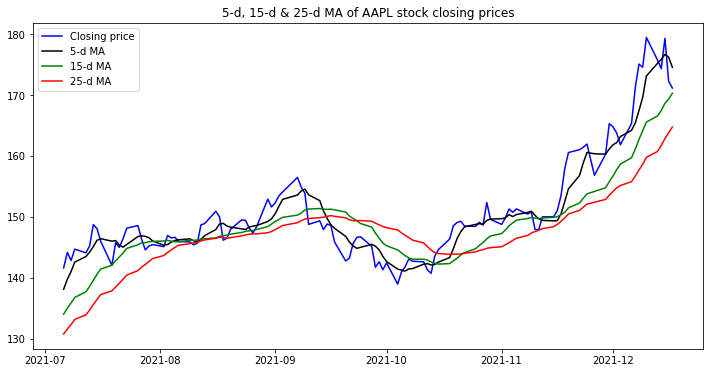

In [7]:
# Let's visualize the MAs in a graph
plt.figure(figsize=(12, 6))
plt.plot(df_apple['Close'], color='blue', label='Closing price')
plt.plot(df_apple['5d_ma_price'], color='black', label='5-d MA')
plt.plot(df_apple['15d_ma_price'], color='green', label='15-d MA')
plt.plot(df_apple['25d_ma_price'], color='red', label='25-d MA')
plt.title("5-d, 15-d & 25-d MA of AAPL stock closing prices")
plt.legend(loc='best')
plt.show()

# 3)- Creating buy/sell signals

- After computing the 25-d MAs, we need to establish a strategy based on which we generate a buy or sell signal. The strategy will be as simple as this: when the asset's close price is below the 25-d MA, and the volume is above the 25-d MA it's a buying signal, and vice versa for selling.

- Next, we'll create two columns indicating which days are having their 25-d MA lower than the closing price, and their volume higher than 25-d MA.

In [27]:
def buy_sell_signal(row):
    # Buying signal
    if row['Close'] <= row['25d_ma_price'] and row['Volume'] >= row['25d_ma_volume']:
        return np.nan, row['Close']
    # Selling signal
    elif row['Close'] > row['25d_ma_price'] and row['Volume'] < row['25d_ma_volume']:
        return row['Close'], np.nan
    # Neutral signal
    else:
        return np.nan, np.nan

df_apple["sell_signal"] = df_apple.apply(lambda row: buy_sell_signal(row)[0], axis=1)
df_apple["buy_signal"] = df_apple.apply(lambda row: buy_sell_signal(row)[1], axis=1)
df_apple.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,5d_ma_price,15d_ma_price,25d_ma_price,25d_ma_volume,sell_signal,buy_signal
Date,,,,,,,,,,,,,
2021-07-06,139.656634,142.727531,139.656634,141.600876,108181800,0.0,0,138.099243,133.994057,130.746602,73844408.0,NaN,NaN
2021-07-07,143.116382,144.462404,142.238989,144.143356,104911600,0.0,0,139.742383,134.986454,131.555807,75335388.0,NaN,NaN
2021-07-08,141.162171,143.634848,140.254853,142.817276,105575500,0.0,0,140.994675,135.856546,132.280862,77187252.0,NaN,NaN
2021-07-09,142.328727,145.220162,142.229016,144.681763,99890800,0.0,0,142.558047,136.741926,133.141115,78133716.0,NaN,NaN
2021-07-12,145.778507,145.888183,143.575023,144.073547,76299700,0.0,0,143.463364,137.675163,133.883318,78178932.0,144.073547,NaN


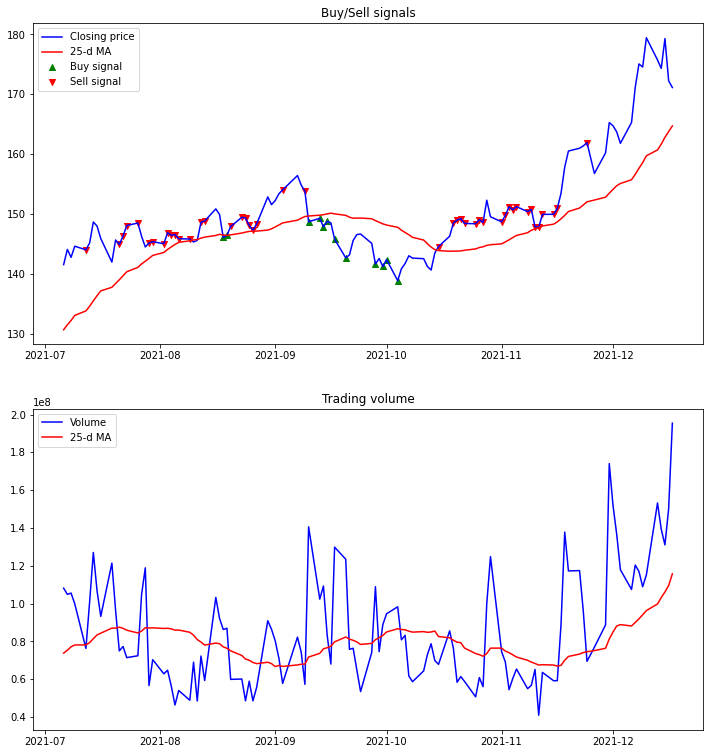

In [38]:
# Let's visualize buying/selling signals in the chart
fig, ax = plt.subplots(2, 1, figsize=(12, 13)) 
ax[0].plot(df_apple['Close'] , label='Closing price', color='blue')
ax[0].plot(df_apple['25d_ma_price'], color='red', label='25-d MA')
ax[0].scatter(df_apple.index , df_apple['buy_signal'], label='Buy signal', marker='^', color='green')
ax[0].scatter(df_apple.index , df_apple['sell_signal'] , label='Sell signal' , marker='v', color='red')
ax[0].set_title("Buy/Sell signals")
ax[0].legend(loc='best')
ax[1].plot(df_apple['Volume'] , label='Volume', color='blue')
ax[1].plot(df_apple['25d_ma_volume'], color='red', label='25-d MA')
ax[1].set_title("Trading volume")
ax[1].legend(loc='best')
plt.show()